In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import datetime

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
mclean_df = pd.read_csv("mclean_county_data_with_geocode.csv")
mclean_df = mclean_df.drop(['Unnamed: 0'], axis=1)

In [3]:
normal_df = pd.read_csv("normal_il_data_w_geocode.csv")
normal_df = normal_df.drop(['Unnamed: 0'], axis=1)

In [4]:
bloomington_df = pd.read_csv("bloomington_il_data_with_geocode.csv")
bloomington_df = bloomington_df.drop(['Unnamed: 0'], axis=1)

In [5]:
#how many accidents were in bloomington, and normal

normal_count = normal_df.shape[0]
bloomington_count = bloomington_df.shape[0]
chicago_count = 2250

BLOOMINGTON_POP = 78902
NORMAL_POP= 54664
CHICAGO_POP = 2719000

blono_crash_per_capita = bloomington_count / float(BLOOMINGTON_POP)
normal_crash_per_capita = normal_count / float(NORMAL_POP)
chicago_crash_per_captia = chicago_count / float(CHICAGO_POP)


print " %0.2f crashes per 10,000 people in bloomington" % ( blono_crash_per_capita * 10000)
print  " %0.2f crashes per 10,000 people in normal" % (normal_crash_per_capita * 10000)
print  " %0.2f crashes per 10,000 people in chicago" % (chicago_crash_per_captia * 10000)



#Going to just use X2 here because lazy, sorry Bayesians.

obs = np.array(([normal_count, NORMAL_POP-normal_count], [bloomington_count, BLOOMINGTON_POP-bloomington_count]))
chi2, p, dof, expected = stats.chi2_contingency(obs)
print 'null hypothesis is that bloomington and normal are equally safe for bikers'
print "p = " +  str(p)
print "fail to reject the null at p < 0.5"

obs = np.array(([normal_count+bloomington_count, NORMAL_POP-normal_count+(BLOOMINGTON_POP-bloomington_count)],[chicago_count, CHICAGO_POP-chicago_count]))
chi2, p, dof, expected = stats.chi2_contingency(obs)
print 'null hypothesis is that bloomington and chicago are equally safe for bikers'
print "p = " +  str(p)
print "reject the null at p < 0.5"


 2.66 crashes per 10,000 people in bloomington
 2.56 crashes per 10,000 people in normal
 8.28 crashes per 10,000 people in chicago
null hypothesis is that bloomington and normal are equally safe for bikers
p = 0.95183165171
fail to reject the null at p < 0.5
null hypothesis is that bloomington and chicago are equally safe for bikers
p = 1.41950511363e-12
reject the null at p < 0.5


# Deeper Statistical Analysis

Problems - 
*  bike accidents are very rare (Future Mike:  Talk to AC.   You've found a zero inflated Poisson problem)
*  not much commonality between these datasets.
*  Bloomington's open data sucks


Approach
* take the common variables I do have
* engineer features
* descriptive stats on when accidents happen maybe?
* could try unsupervised ML
* ???

In [6]:
complete_df = bloomington_df.append([normal_df, mclean_df], ignore_index=True)

In [7]:
#break out month, day, year

def get_month_day_year(date):
    month, day, year = date.split("/")

    return int(month), int(day), int(year)

complete_df['month'], complete_df['day'], complete_df['year'] = zip(*complete_df.date.map(get_month_day_year))

In [8]:
#time as an hour bin (could also do seconds of day or something for continuous, this is more human understandable)

def bin_hours(time):
    hour = int(time.split(':')[0])
    am_pm = time.split(' ')[1].lower()
    if am_pm == 'pm':
        hour +=12
    return hour

complete_df['hour_bin'] = complete_df.time.map(bin_hours)

In [9]:
#clean up lat and long

def clean_lat_long(x):
    x = x.strip('[]')
    latitude, longitude = x.split(',')
    return float(latitude), float(longitude)


complete_df['latitude'], complete_df['longitude'] = zip(*complete_df.lat_long.map(clean_lat_long))      

In [10]:
#day of week feature

def day_of_week(date):
    month, day, year = (int(x) for x in date.split('/'))
    if year < 99:
        year = 2000 + year   #do you want y3k, because this is how you get y3k
    dt = datetime.date(year, month, day)
    return dt.strftime("%A")

complete_df['day_of_week'] = complete_df.date.map(day_of_week)

In [11]:
complete_df.shape

(37, 32)

###TODO

*  MDS 
*  K-Means

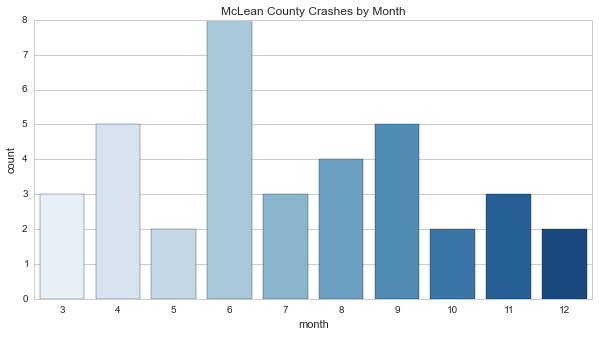

In [13]:
#visualize month
plt.figure(figsize=(10,5))
plt.title("McLean County Crashes by Month")
sns.countplot(x="month", data=complete_df, palette="Blues", order =[3,4,5,6,7,8,9,10,11,12])
plt.legend()

In [79]:
range(0,24,1)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]

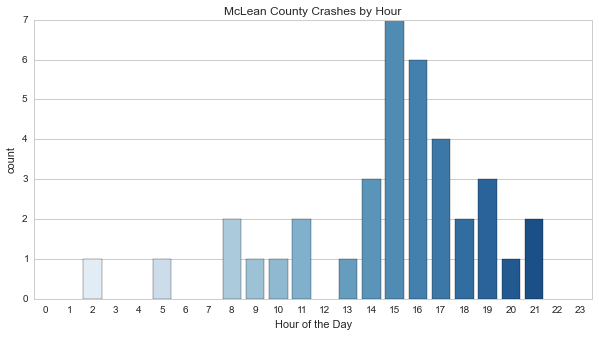

In [14]:
#visualize time
plt.figure(figsize=(10,5))
plt.title("McLean County Crashes by Hour")
sns.countplot(x="hour_bin", data=complete_df, palette="Blues", order = range(0,24,1))
plt.xlabel("Hour of the Day")
plt.legend()

#  order = sorted(complete_df.hour_bin.unique()

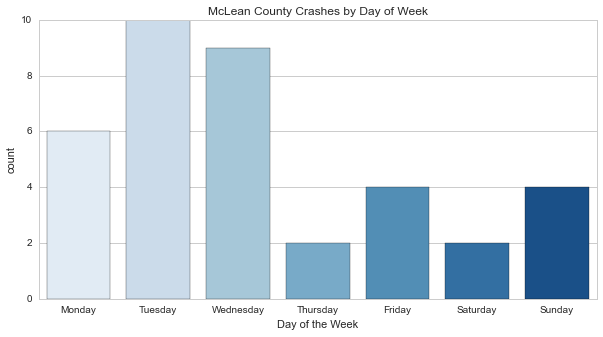

In [15]:
#visualize day
plt.figure(figsize=(10,5))
plt.title("McLean County Crashes by Day of Week")
sns.countplot(x="day_of_week", data=complete_df, palette="Blues", order =['Monday', 'Tuesday', 
                                                                             'Wednesday', 'Thursday','Friday',
                                                                             'Saturday','Sunday'] )
plt.xlabel("Day of the Week")
plt.legend()

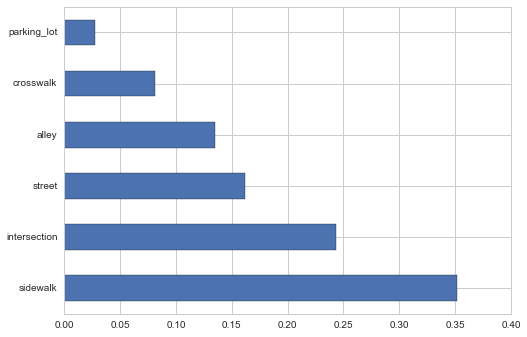

In [16]:
#where were the bikes before a crash
bike_locs_percent= complete_df.location_bike.value_counts() / complete_df.location_bike.value_counts().sum()
bike_locs_percent.plot(kind='barh')

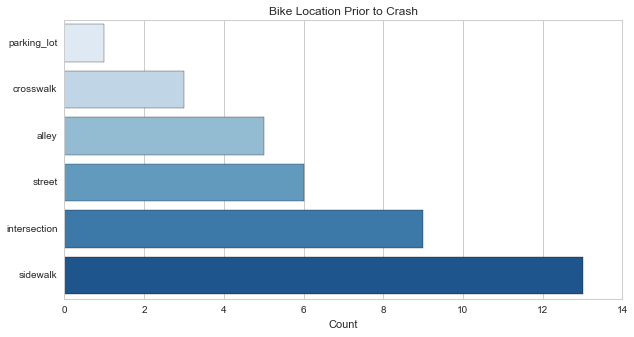

In [18]:
plt.figure(figsize=(10,5))
plt.title("Bike Location Prior to Crash")
sns.countplot( y="location_bike", data=complete_df,  palette="Blues", order=['parking_lot', 'crosswalk','alley',
                                                                             'street', 'intersection', 'sidewalk'])
plt.ylabel("")
plt.xlabel("Count")
plt.legend()

In [66]:
complete_df.fault.value_counts()

cyclist     16
motorist    11
unknown      9
none         1
dtype: int64

In [67]:
complete_df.shape

(37, 32)

In [69]:
16/37.0

0.43243243243243246

In [70]:
complete_df.columns

Index([u'id', u'date', u'time', u'fault', u'motorist_name', u'motorist_gender',
       u'insured', u'veh_make', u'veh_model', u'veh_year', u'cyclist_name',
       u'cyclist_gender', u'bike', u'geo_loc', u'location_car',
       u'location_bike', u'arrest', u'officer_id', u'm_citation', u'm_section',
       u'c_citation', u'c_section', u'hospital', u'summary', u'lat_long',
       u'month', u'day', u'year', u'hour_bin', u'latitude', u'longitude',
       u'day_of_week'],
      dtype='object')

In [72]:
complete_df.cyclist_gender.value_counts()

m           25
f            7
male         2
unknown      2
redacted     1
dtype: int64

In [73]:
27/34.0  #79% male

0.7941176470588235

In [19]:
complete_df.summary

0                       driver hit cyclist in crosswalk
1     cyclist ran red light at intersection, driver ...
2     cyclist ran stop sign, traveling against traff...
3     cyclist traveling wrong way down alley, hit by...
4     cyclist didn't stop at intersection of alley a...
5     cyclist riding against traffic on sidewalk, hi...
6     motorist hit cyclist at intersection.  Motoris...
7     cyclist hit by car racing yellow light at inte...
8     cyclist riding against traffic on sidewalk, hi...
9     cyclist riding the wrong way on vetrans parkwa...
10    motorist hit cyclist, hit and run.  Motorist r...
11       cyclist on sidewalk hit at intersection by car
12                               cyclist rear ended car
13              cyclist struck motorist at intersection
14    cyclist struck motorist at intersection – conn...
15    cyclist lost control and hit motorist at low s...
16    cyclist struck by car turning left.   Hit and run
17    cyclist struck car while leaving alley.  B